<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Plan" data-toc-modified-id="Plan-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plan</a></span></li><li><span><a href="#Brownian-motion" data-toc-modified-id="Brownian-motion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Brownian motion</a></span></li><li><span><a href="#Monte-Carlo" data-toc-modified-id="Monte-Carlo-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Monte Carlo</a></span></li><li><span><a href="#LETF" data-toc-modified-id="LETF-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LETF</a></span></li></ul></div>

## Packages

In [14]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import sys
import json
import fastparquet

ModuleNotFoundError: No module named 'fastparquet'

In [13]:
%pip install fastparquet

  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\djeca\\AppData\\Local\\Temp\\pip-install-4832lg0f\\fastparquet\\setup.py'"'"'; __file__='"'"'C:\\Users\\djeca\\AppData\\Local\\Temp\\pip-install-4832lg0f\\fastparquet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\djeca\AppData\Local\Temp\pip-wheel-pqnwof8j'
       cwd: C:\Users\djeca\AppData\Local\Temp\pip-install-4832lg0f\fastparquet\
  Complete output (45 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\api.py -> build\lib.win-amd64-3.8\fastparquet


  Running setup.py clean for fastparquet
  Created wheel for thrift: filename=thrift-0.13.0-py3-none-any.whl size=155593 sha256=1267ca7226279b0d9ad2139a849e6f32e3621dc9c13fc6c01f7d80156994cb41
  Stored in directory: c:\users\djeca\appdata\local\pip\cache\wheels\0a\52\7e\8054b57725b8f2b9ddbaacb81b271b939681cc03f8231e6ebc
Successfully built thrift
Failed to build fastparquet
    Running setup.py install for fastparquet: started
    Running setup.py install for fastparquet: finished with status 'error'



  copying fastparquet\compression.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\converted_types.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\core.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\dataframe.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\encoding.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\schema.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\thrift_structures.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\util.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\writer.py -> build\lib.win-amd64-3.8\fastparquet
  copying fastparquet\__init__.py -> build\lib.win-amd64-3.8\fastparquet
  running egg_info
  writing fastparquet.egg-info\PKG-INFO
  writing dependency_links to fastparquet.egg-info\dependency_links.txt
  writing requirements to fastparquet.egg-info\requires.txt
  writing top-level names to fastparquet.egg-info\top_level.txt
  read

## Data

We load prepared in xlsx file data for the underlyings TR

In [2]:
link = 'Data/Underlyings from ICE.xlsx'

In [3]:
Data = pd.read_excel(io=link, index_col=0, parse_dates=True)

# Calulate log difference
Data['logdif_7_10'] = np.log(Data.Under_7_10) - np.log(Data.Under_7_10.shift(1)) 
Data['logdif_20'] = np.log(Data.Under_20) - np.log(Data.Under_20.shift(1)) 

# Make horizon of 3 years
Data2 = Data.loc['2019-02-28':'2021-02-28']

For the Brownian Motion, we will calculate mean/volatility

In [4]:
Parameters = {}

Parameters['Three years'] = [Data2.Under_7_10[-1],
                             Data2.logdif_7_10.mean(),
                             Data2.logdif_7_10.std()]

## Plan

- Create Brownian motion, with simulation
- Create LETF and rebalance
- Create Monte Carlo

## Brownian motion

In [5]:
# UDF to generate error terms ( need for simple)
def Create_Errors(what,horizon):
    
    if what == 'Stand Norm':

        Stand_Residuals = [random.gauss(0,1) for x in range(horizon)]

    return Stand_Residuals

In [6]:
class Brownian_Motion(): # Currently for constant mu and sigma
    
    def __init__(self,Inital_Price, TimeDelta, mu, sigma):
        
        self.Inital_Price = float(Inital_Price)
        self.TimeDelta = int(TimeDelta)
        self.mu = float(mu)
        self.sigma = float(sigma)
        
    def Simulate_Prices(self,epsilons):
        
        predited_prices = []
        predited_prices.append([0,self.Inital_Price])
        
        for i, epsilon in enumerate(epsilons,start=1):
            
            if len(predited_prices) == 1:
                
                num1 = (self.mu - np.power(self.sigma,2)/2)*self.TimeDelta 
                num2 = self.sigma*epsilon*np.sqrt(self.TimeDelta)

                iPrice = self.Inital_Price*np.exp(num1-num2)

                predited_prices.append([i,iPrice])
                
            else:
                
                num1 = (self.mu - np.power(self.sigma,2)/2)*self.TimeDelta
                num2 = self.sigma*epsilon*np.sqrt(self.TimeDelta)

                iPrice = iPrice*np.exp(num1-num2)

                predited_prices.append([int(i),iPrice])
        
        predited_prices = pd.DataFrame(predited_prices)
        
        predited_prices.columns = ['day','price']
        
        predited_prices.set_index('day', inplace=True)
        
        return predited_prices
    
    def __repr__(self):
        return '''
Initial Price {0}
Time Delta {1}
Mu {2}
Sigma {3}
'''.format(self.Inital_Price,self.TimeDelta, self.mu,self.sigma)
        

## Monte Carlo

In [7]:
def Monte_Carlo(Inital_Price, TimeDelta, mu, sigma,
                       n_simulations = 5000, 
                       error_type = 'Stand Norm', n_holding_days = 5):
    
    BM_i = Brownian_Motion(Inital_Price, TimeDelta, mu, sigma) # create brownian motion
    
    Simulated_DF = pd.DataFrame()
    
    for iSim in range(n_simulations): # For each simulation

        # create simulated errors
        Errors_i = Create_Errors(error_type,n_holding_days)

        # create returns of underlying for errors
        Simulation_i = BM_i.Simulate_Prices(Errors_i)
        
        # Rename column
        Simulation_i.columns = ['Price_'+str(iSim)]
        
        # Add data
        
        Simulated_DF = pd.concat([Simulated_DF, Simulation_i],axis=1)
        
    return Simulated_DF

In [8]:
Data_5 = Monte_Carlo(Inital_Price=Parameters['Three years'][0],
                    TimeDelta=1,
                    mu=Parameters['Three years'][1],
                    sigma=Parameters['Three years'][2],
                    n_holding_days=5,
                    n_simulations = 10000)

Data_30 = Monte_Carlo(Inital_Price=Parameters['Three years'][0],
                    TimeDelta=1,
                    mu=Parameters['Three years'][1],
                    sigma=Parameters['Three years'][2],
                    n_holding_days=30,
                    n_simulations = 10000)

Data_252 = Monte_Carlo(Inital_Price=Parameters['Three years'][0],
                    TimeDelta=1,
                    mu=Parameters['Three years'][1],
                    sigma=Parameters['Three years'][2],
                    n_holding_days=252,
                    n_simulations = 10000)

In [9]:
# I saved file, but code is rather effient -> 2 min 37 seconds to generate all needed data for 10000

Data_5.to_csv('Data/Simulated_data_5.csv')
Data_30.to_csv('Data/Simulated_data_30.csv')
Data_252.to_csv('Data/Simulated_data_252.csv')

In [10]:
Data_252.to_parquet('Data/Simulated_data_252.gzip',
              compression='gzip') 

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

## LETF

In [18]:
def Quick_LETF_Return(Index_return, Leverage, Fees=0):
    return Index_return*Leverage-Fees/252

In [64]:
def Mine_LETF(Data,Leverage, Fees=0):
    
    NewData = Data.pct_change().fillna(0)

    NewData = NewData.apply(Quick_LETF_Return, args=(Leverage,Fees))

    NewData = NewData + 1

    NewData = NewData.cumprod()
    
    return NewData

In [81]:
# plot it

def plot_it(Simulated_Data):

    fig, ax = plt.subplots(figsize=(16, 9))

    for iKey in Simulated_Data.columns:

        ax.plot(Simulated_Data[iKey], color = 'blue')

    
    ax.set(xlabel='day', ylabel='Return',
           title='Simulation')
    ax.grid()

    #fig.savefig("251_simple_2x.png")
    plt.show()

In [82]:
# plot it

def plot_it_2(Simulated_Data,Simulated_Data_fee):

    fig, ax = plt.subplots(figsize=(16, 9))

    for iKey in Simulated_Data.columns:

        ax.plot(Simulated_Data[iKey], color = 'blue')

    for iKey in Simulated_Data_fee.columns:

        ax.plot(Simulated_Data_fee[iKey], color = 'red')

    
    ax.set(xlabel='day', ylabel='Return',
           title='Simulation')
    ax.grid()

    plt.show()

In [83]:
LETF_Data_3 = Mine_LETF(Data_252,3)
LETF_Data_3_fee = Mine_LETF(Data_252,3,0.02)

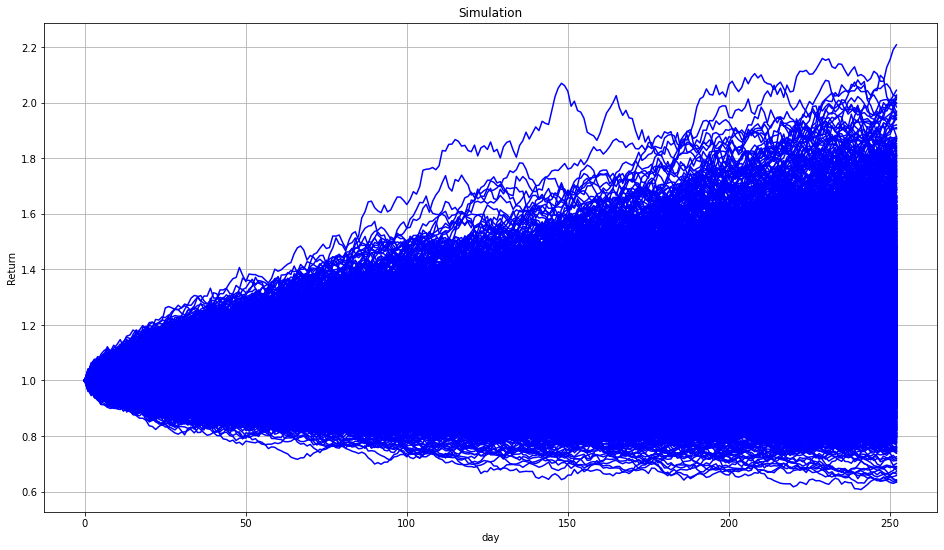

In [85]:
plot_it(LETF_Data_3)

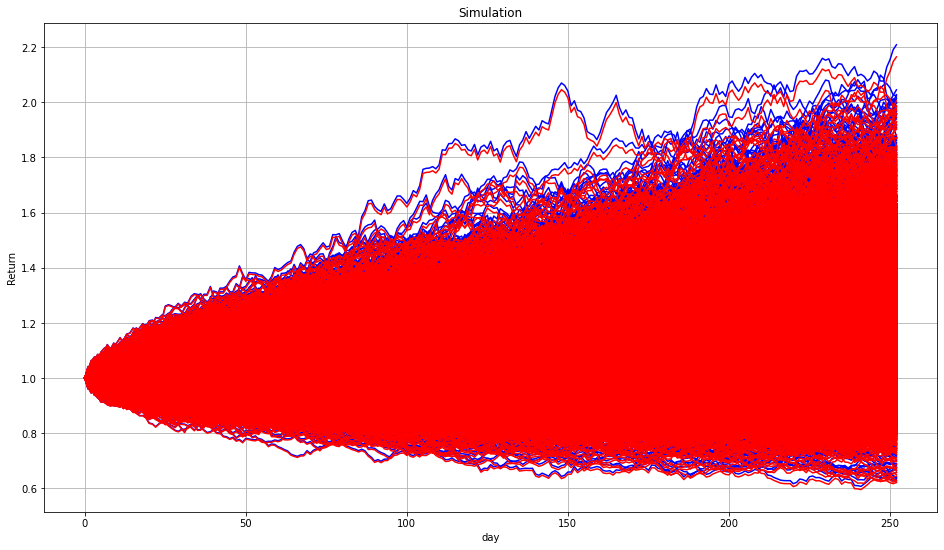

In [87]:
plot_it_2(LETF_Data_3,LETF_Data_3_fee)